In [1]:
import pandas as pd


## Data Fields Description

| Field Name       | Data Type  | Description                                                                                       |
|------------------|------------|---------------------------------------------------------------------------------------------------|
| publisher_id     | uint16_t   | The publisher ID assigned by Databento, which denotes the dataset and venue.                      |
| instrument_id    | uint32_t   | The numeric instrument ID.                                                                        |
| ts_event         | uint64_t   | The matching-engine-received timestamp expressed as the number of nanoseconds since the UNIX epoch.|
| price            | int64_t    | The order price where every 1 unit corresponds to 1e-9, i.e. 1/1,000,000,000 or 0.000000001.       |
| size             | uint32_t   | The order quantity.                                                                               |
| action           | char       | The event action. Always Trade in the TBBO schema. See Action.                                    |
| side             | char       | The side that initiates the event. Can be Ask for a sell aggressor, Bid for a buy aggressor, or None where no side is specified by the original trade.|
| flags            | uint8_t    | A bit field indicating event end, message characteristics, and data quality. See Flags.           |
| depth            | uint8_t    | The book level where the update event occurred.                                                   |
| ts_recv          | uint64_t   | The capture-server-received timestamp expressed as the number of nanoseconds since the UNIX epoch.|
| ts_in_delta      | int32_t    | The matching-engine-sending timestamp expressed as the number of nanoseconds before ts_recv.      |
| sequence         | uint32_t   | The message sequence number assigned at the venue.                                                |
| bid_px_00        | int64_t    | The bid price at the top level.                                                                   |
| ask_px_00        | int64_t    | The ask price at the top level.                                                                   |
| bid_sz_00        | uint32_t   | The bid size at the top level.                                                                    |
| ask_sz_00        | uint32_t   | The ask size at the top level.                                                                    |
| bid_ct_00        | uint32_t   | The number of bid orders at the top level.                                                        |
| ask_ct_00        | uint32_t   | The number of ask orders at the top level.                                                        |


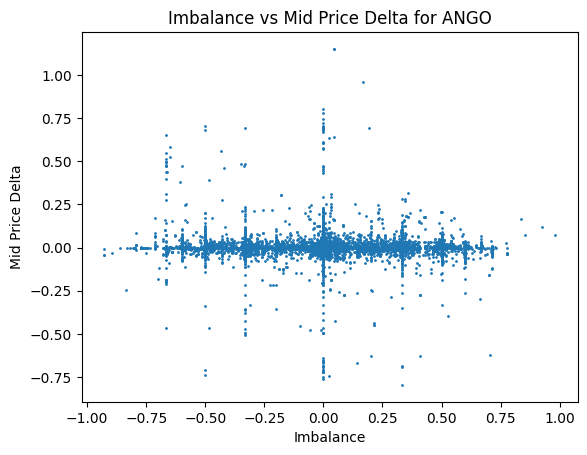

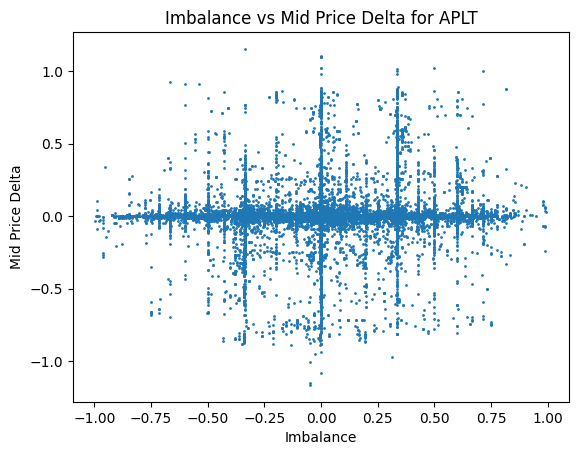

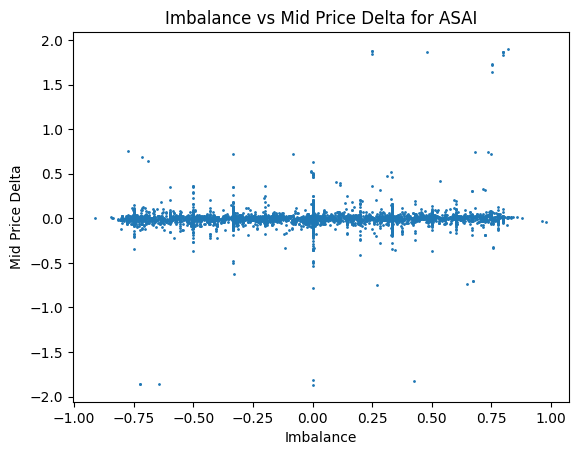

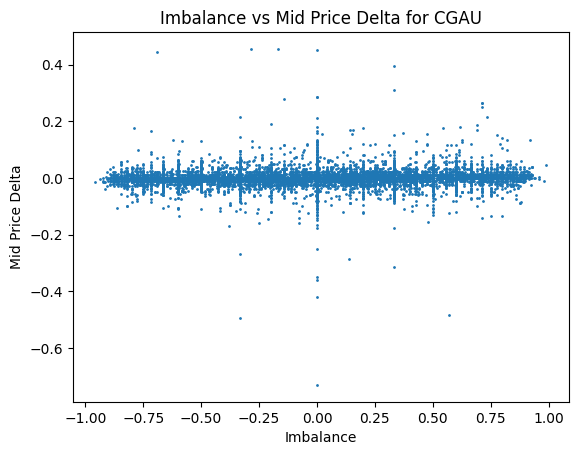

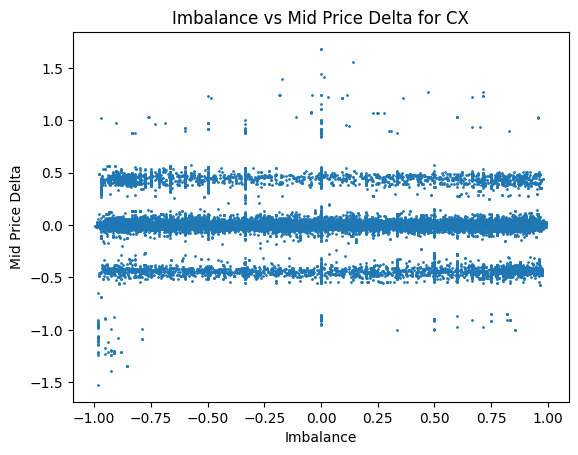

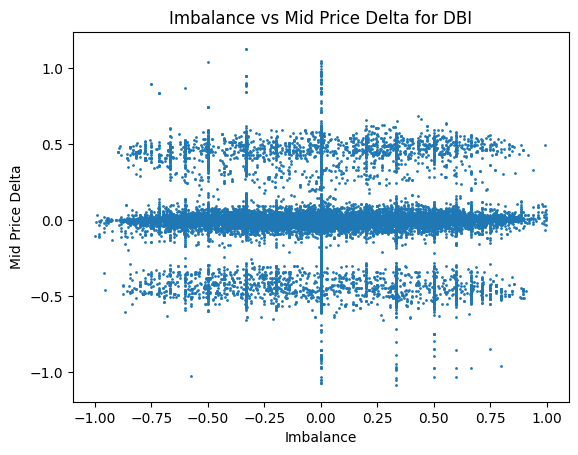

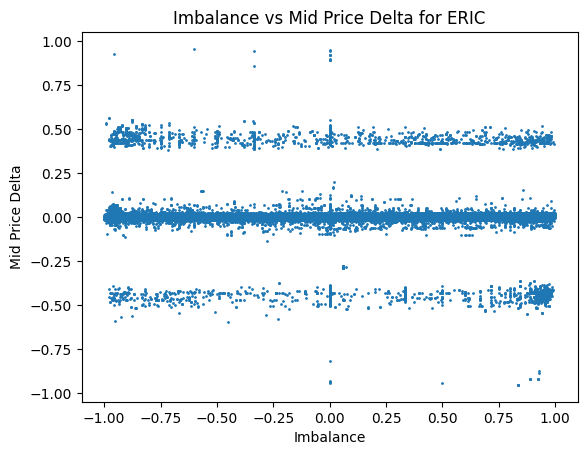

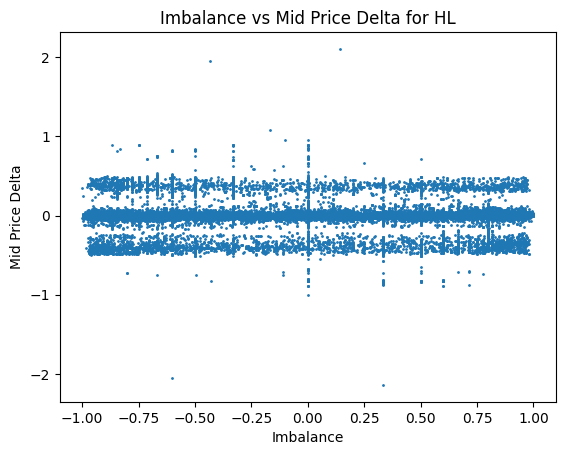

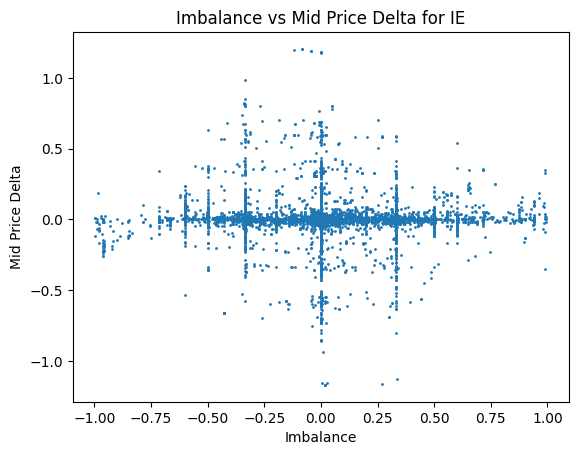

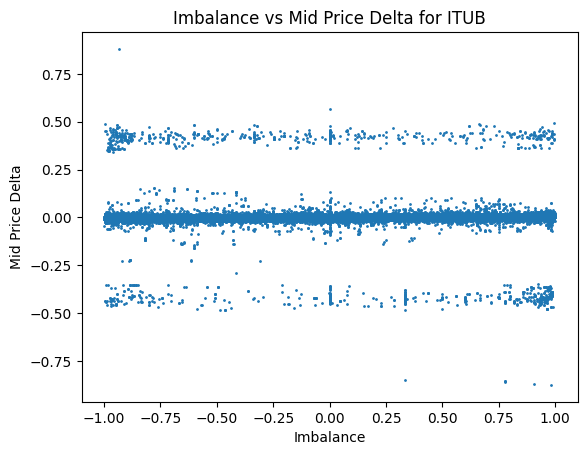

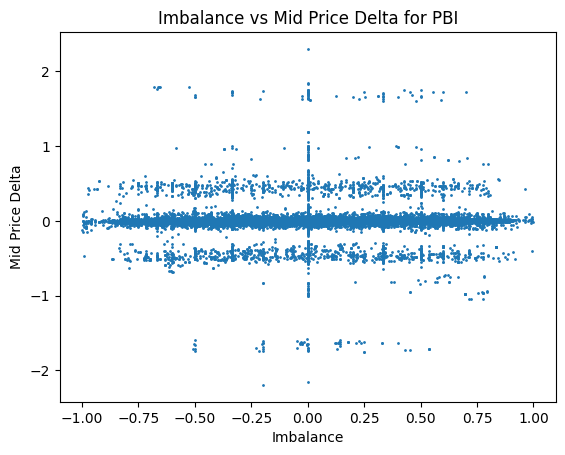

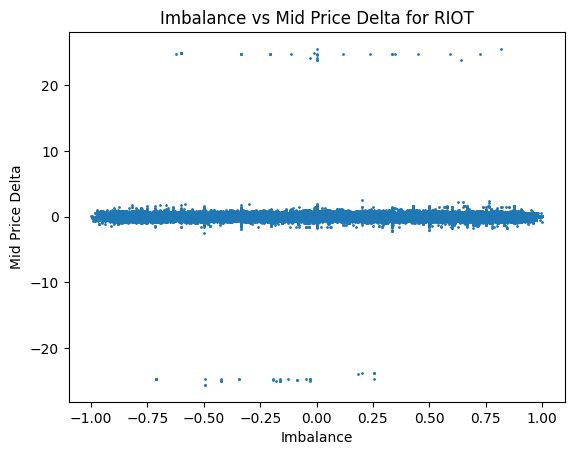

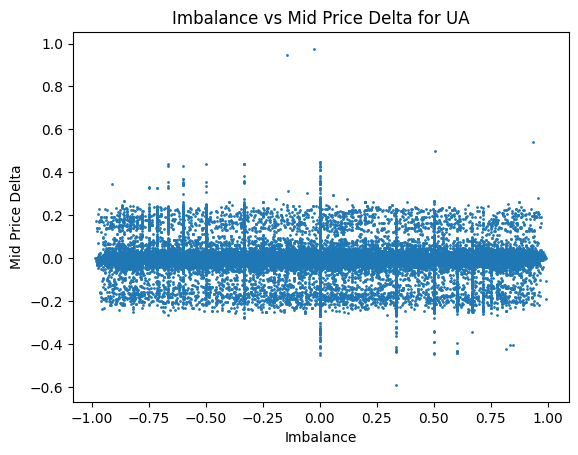

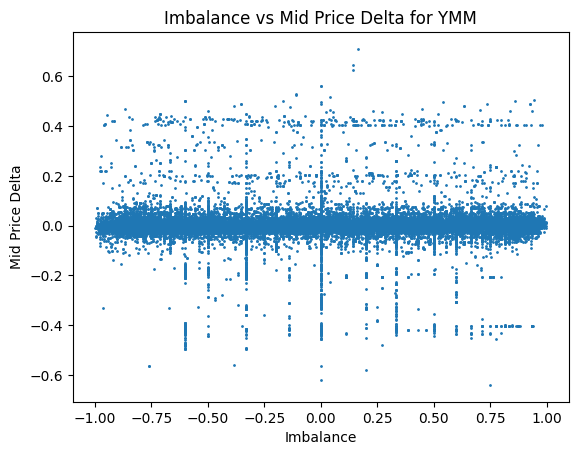

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the TBBO.csv file
tbbo_data = pd.read_csv("Data_csv/TBBO.csv")

# Group the data by symbol
grouped_data = tbbo_data.groupby("symbol")

# Function to calculate imbalance and plot price in 10 trades after
def analyze_symbol(data):
    # Calculate the bid-ask imbalance
    data["imbalance"] = (data["bid_sz_00"] - data["ask_sz_00"]) / (data["bid_sz_00"] + data["ask_sz_00"])

    # Calculate the mid-price
    data["mid_price"] = (data["bid_px_00"] + data["ask_px_00"]) / 2

    # Calculate the delta of the mid-price over a horizon of 10 trades
    data["mid_price_delta"] = data["mid_price"].shift(-10) - data["mid_price"]

    # Calculate the long-term bid-ask spread
    long_term_spread = data["ask_px_00"].mean() - data["bid_px_00"].mean()

    # Normalize the mid-price delta by the long-term bid-ask spread
    data["normalized_mid_price_delta"] = data["mid_price_delta"] / long_term_spread

    # Plot the price in 10 trades after in function of the current imbalance
    plt.scatter(data["imbalance"], data["mid_price_delta"],s=1)
    plt.xlabel("Imbalance")
    plt.ylabel("Mid Price Delta")
    plt.title(f"Imbalance vs Mid Price Delta for {data['symbol'].iloc[0]}")
    plt.show()

# Apply the analysis function to each symbol
for symbol, data in grouped_data:
    analyze_symbol(data)    



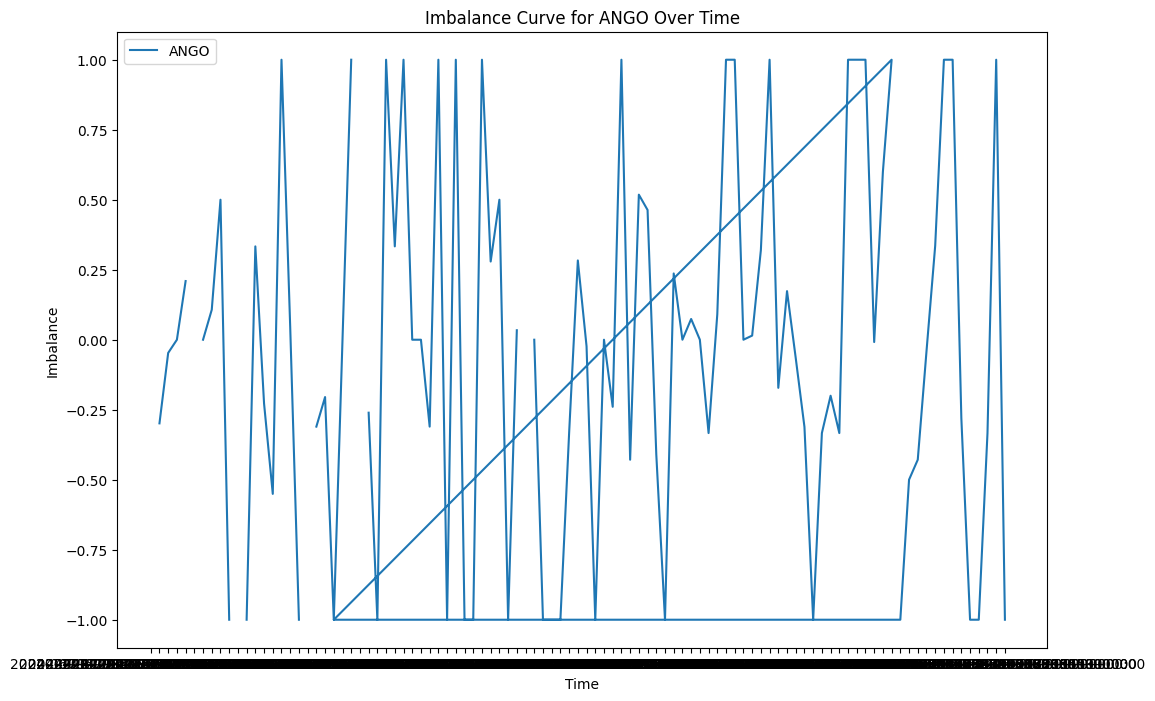

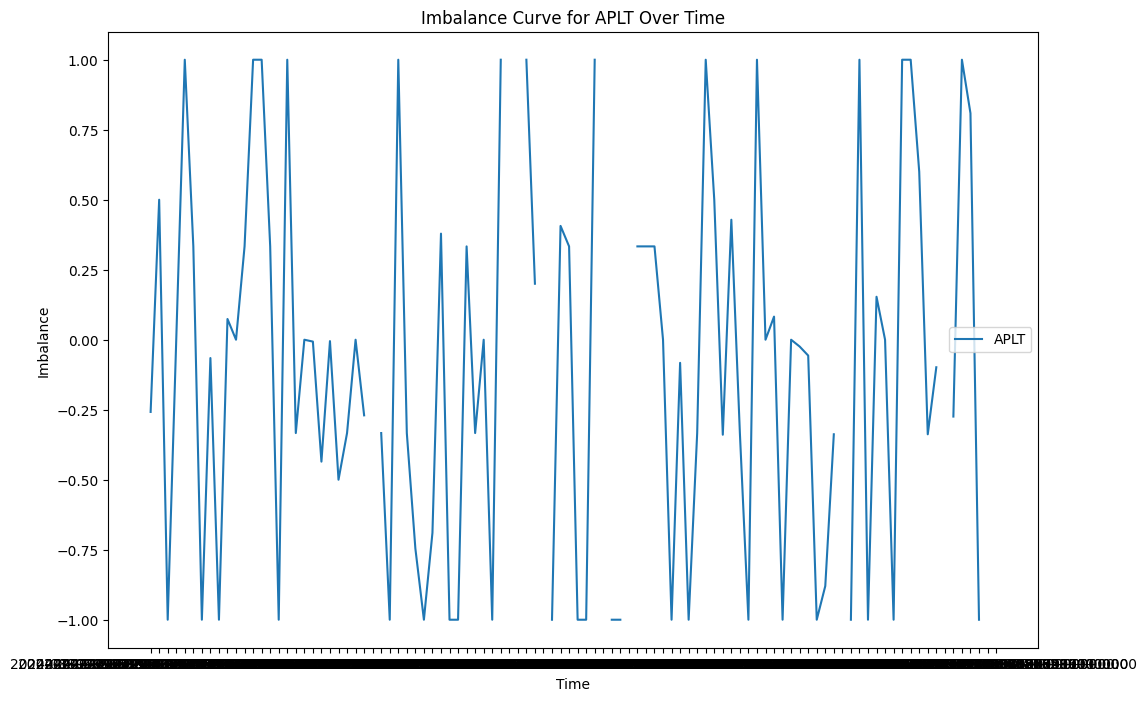

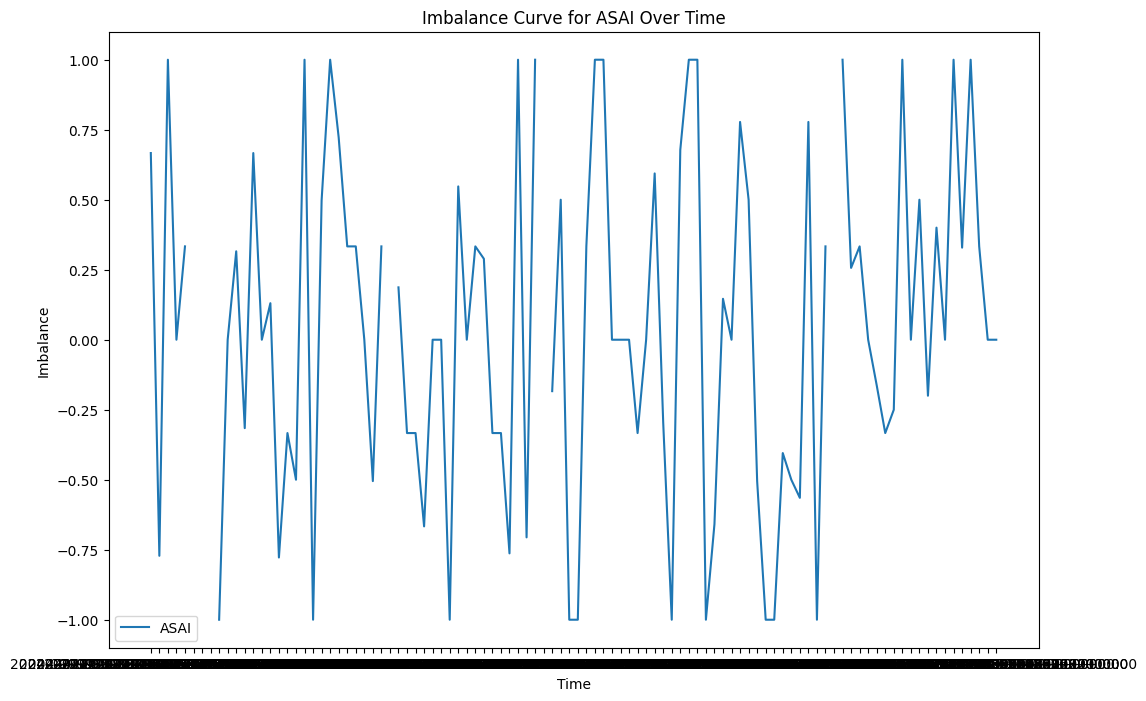

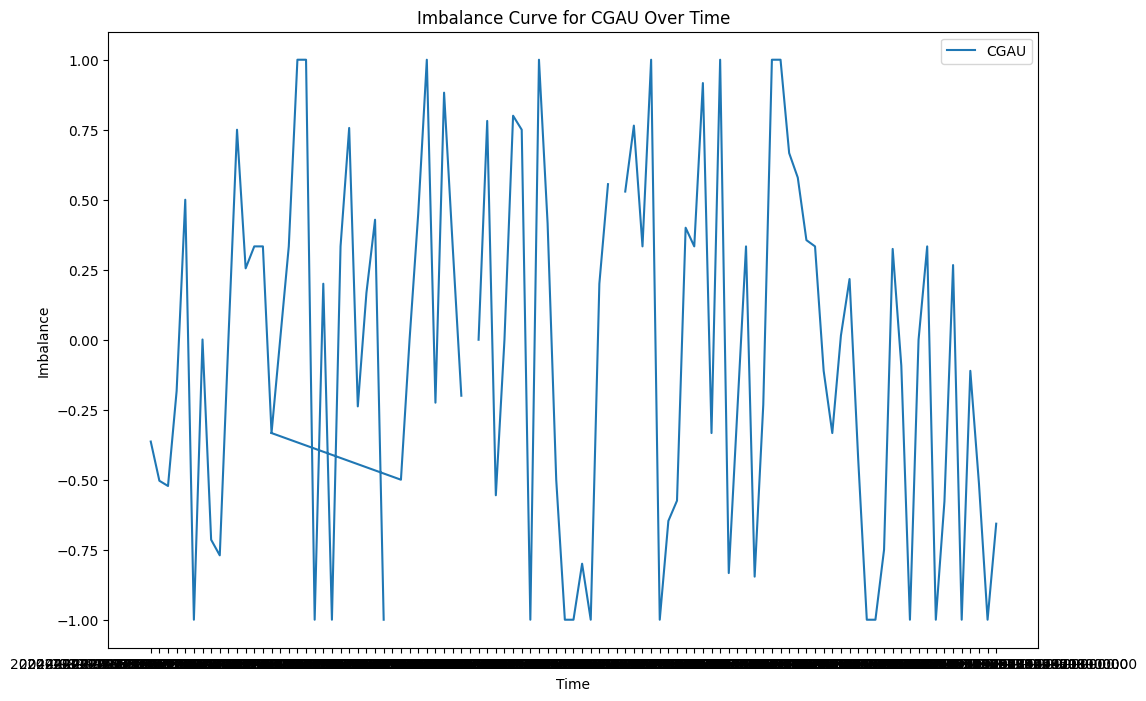

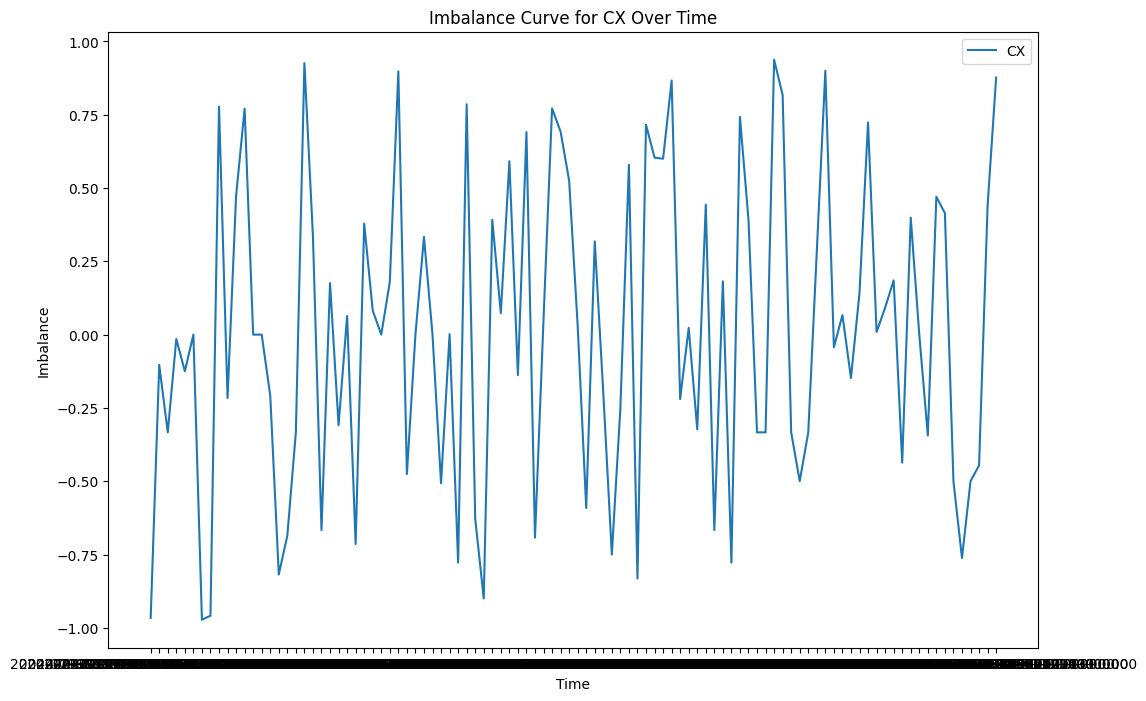

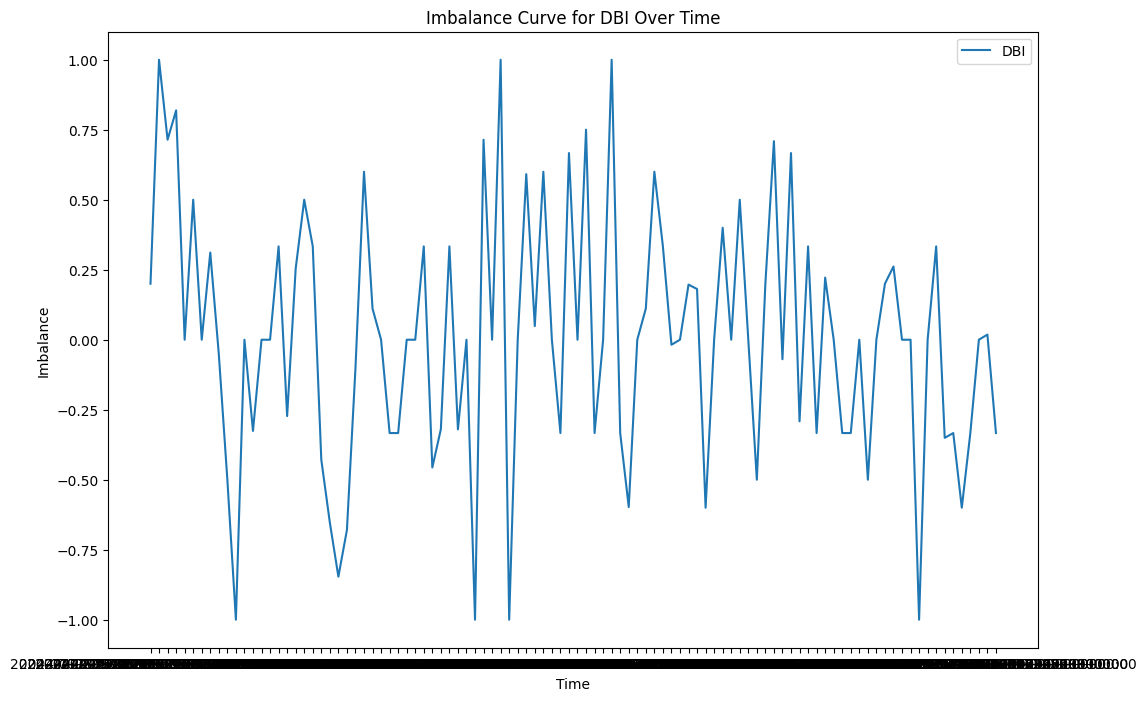

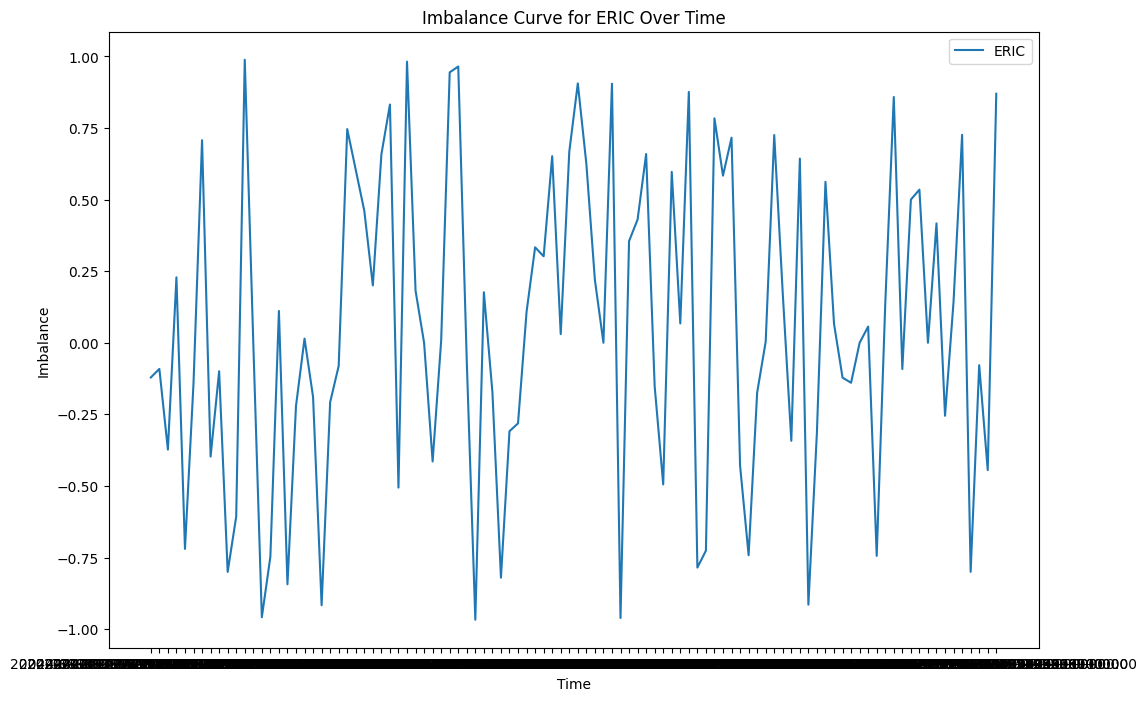

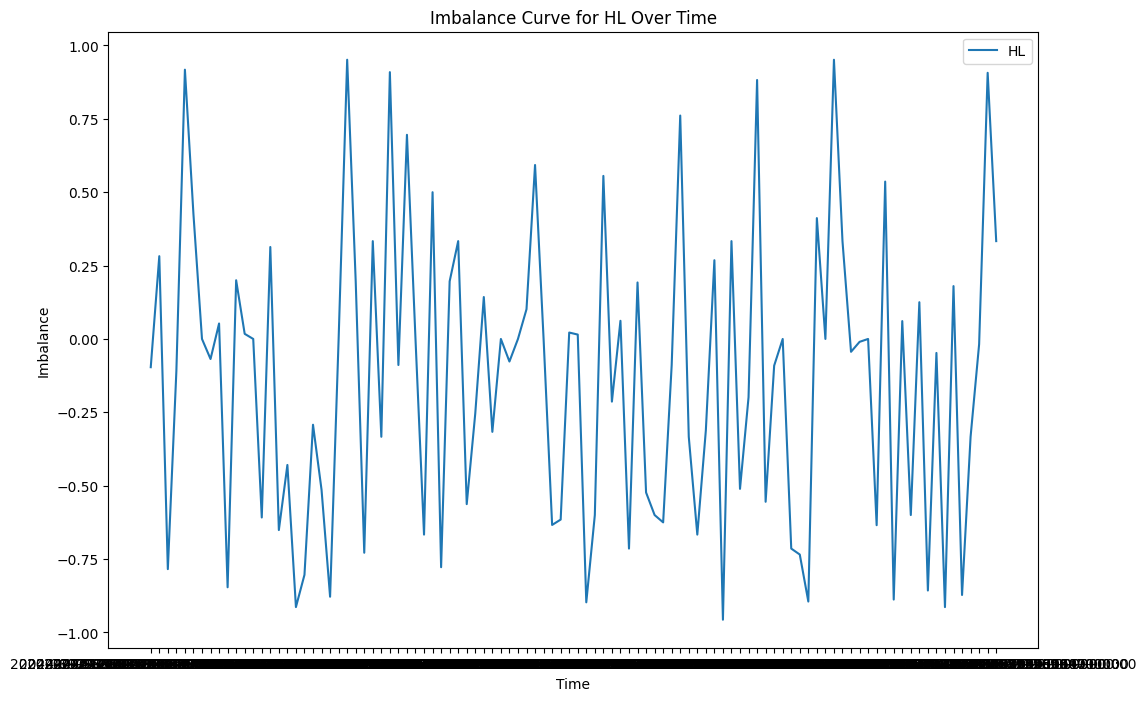

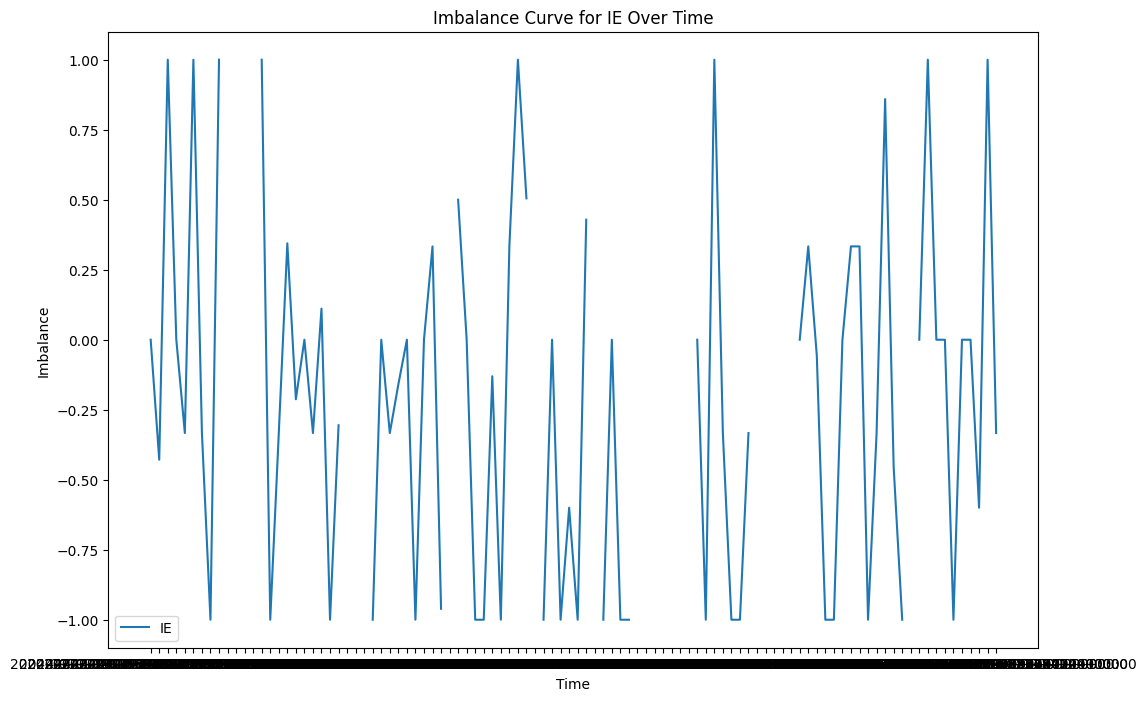

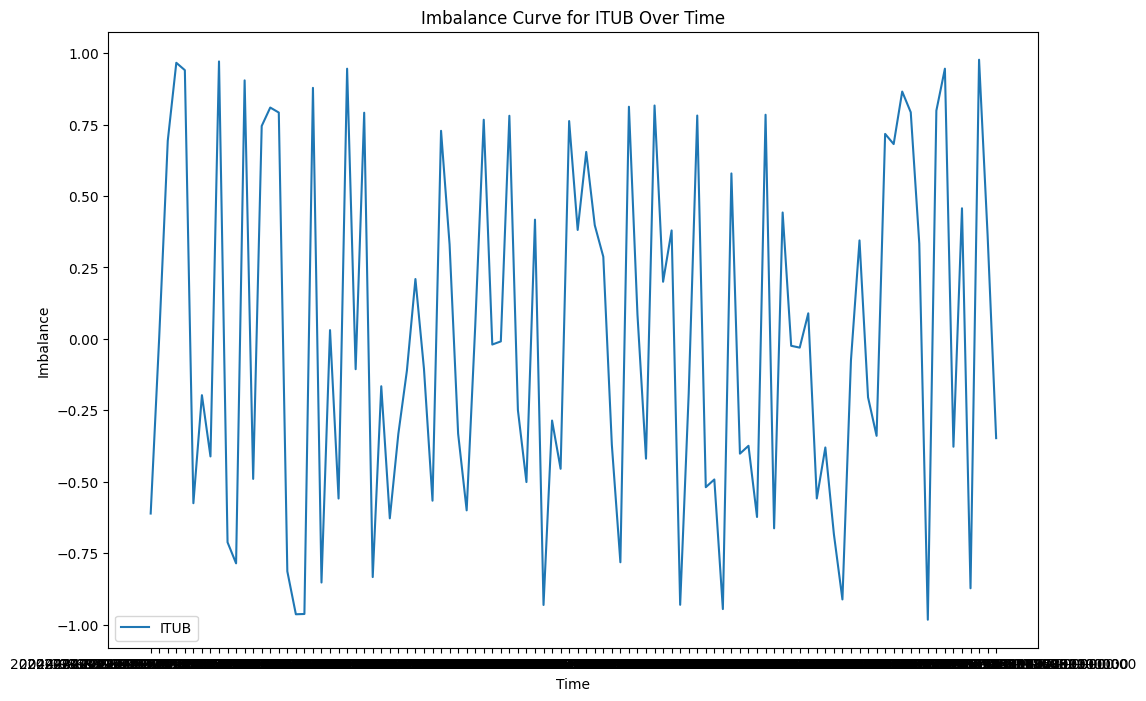

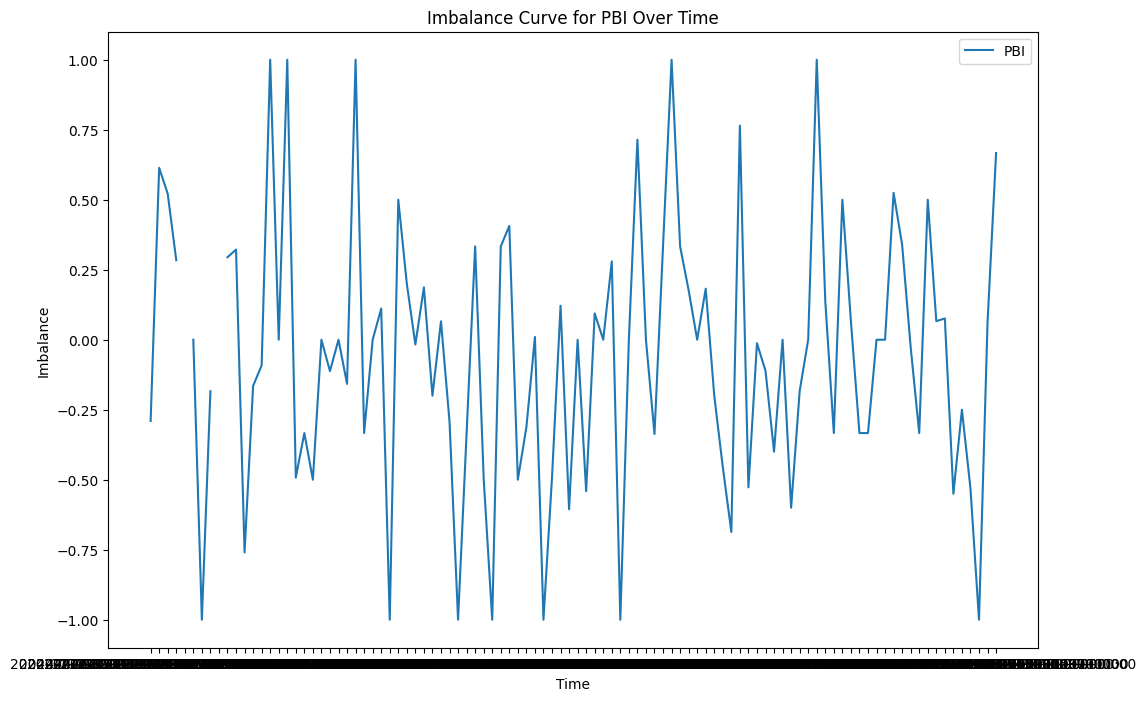

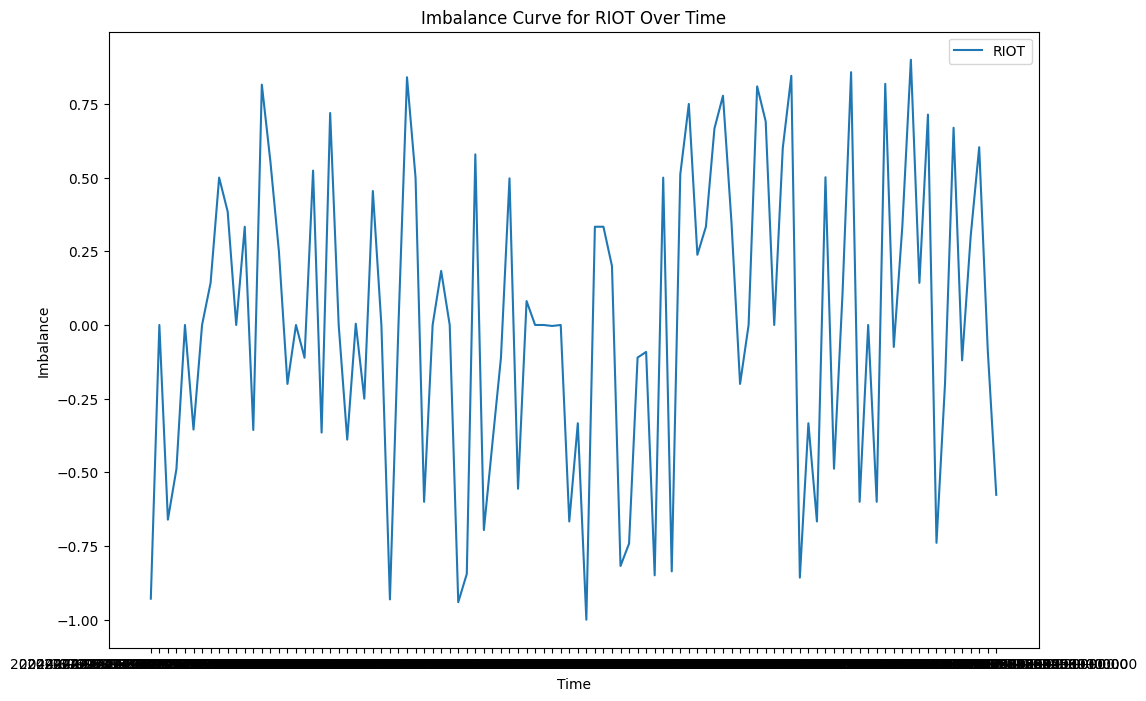

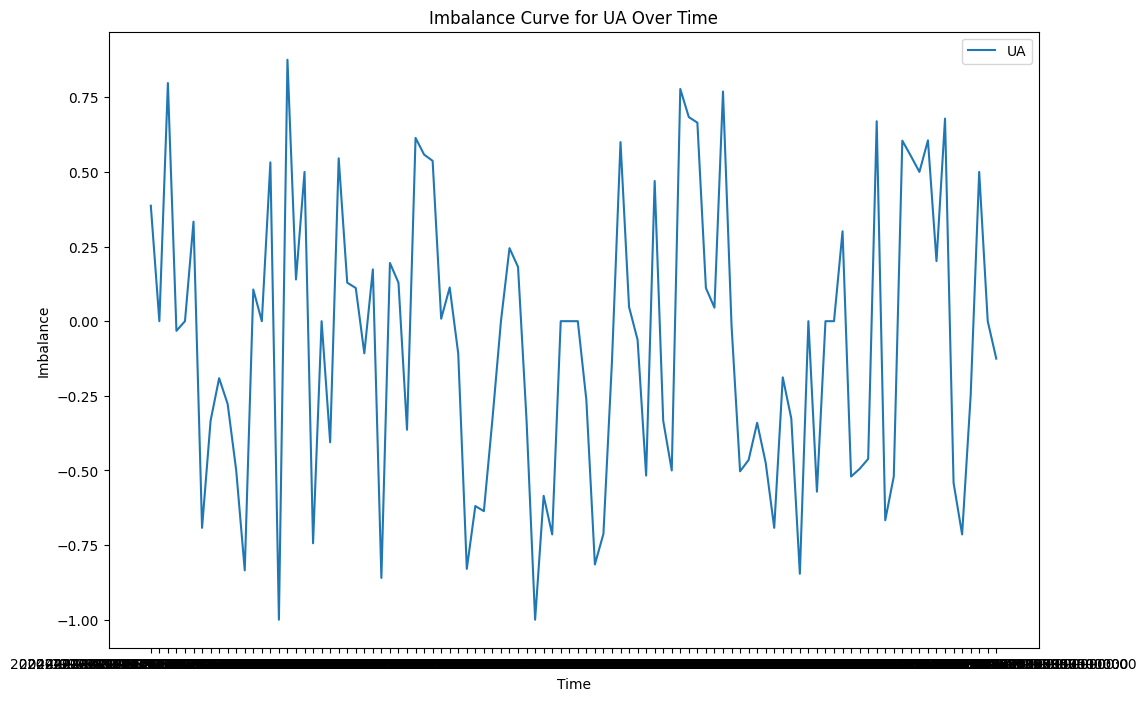

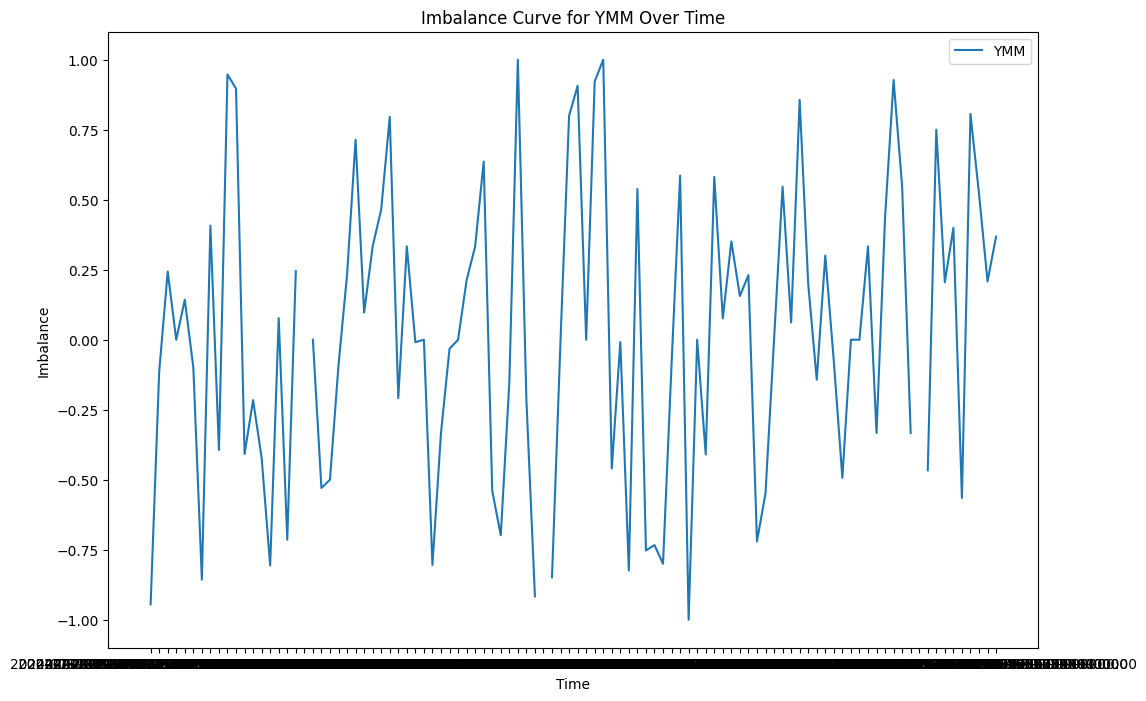

In [4]:
# Function to plot imbalance curves for a small part of the dataset
def plot_imbalance_curves_small_sample(grouped_data, sample_size=100):
    for symbol, data in grouped_data:
        plt.figure(figsize=(12, 8))
        
        # Take a small sample of the data
        data_sample = data.sample(n=sample_size, random_state=1)
        
        # Calculate the bid-ask imbalance
        data_sample["imbalance"] = (data_sample["bid_sz_00"] - data_sample["ask_sz_00"]) / (data_sample["bid_sz_00"] + data_sample["ask_sz_00"])
        
        # Check if 'ts_recv' column exists
        if "ts_recv" in data_sample.columns:
            # Plot the imbalance as a function of time
            plt.plot(data_sample["ts_recv"], data_sample["imbalance"], label=symbol)
        else:
            print(f"Warning: 'ts_recv' column not found for symbol {symbol}")
        
        plt.xlabel("Time")
        plt.ylabel("Imbalance")
        plt.title(f"Imbalance Curve for {symbol} Over Time")
        plt.legend()
        plt.show()

# Call the function to plot imbalance curves for a small sample
plot_imbalance_curves_small_sample(grouped_data)


In [9]:
import pandas as pd

def calculate_descriptive_statistics(data):
    """
    Calculate descriptive statistics and liquidity indicators for the given dataset.
    
    Parameters:
    data (pd.DataFrame): The dataset containing order book data.
    
    Returns:
    pd.DataFrame: A DataFrame containing the calculated statistics.
    """
    stats = {}
    
    # Calculate bid-ask spread
    data["bid_ask_spread"] = data["ask_px_00"] - data["bid_px_00"]
    
    # Calculate mid price
    data["mid_price"] = (data["ask_px_00"] + data["bid_px_00"]) / 2
    
    # Calculate mean and standard deviation of bid-ask spread
    stats["mean_bid_ask_spread"] = data["bid_ask_spread"].mean()
    stats["std_bid_ask_spread"] = data["bid_ask_spread"].std()
    
    # Calculate mean and standard deviation of mid price
    stats["mean_mid_price"] = data["mid_price"].mean()
    stats["std_mid_price"] = data["mid_price"].std()
    
    # Calculate mean and standard deviation of bid size and ask size
    stats["mean_bid_size"] = data["bid_sz_00"].mean()
    stats["std_bid_size"] = data["bid_sz_00"].std()
    stats["mean_ask_size"] = data["ask_sz_00"].mean()
    stats["std_ask_size"] = data["ask_sz_00"].std()
    
    # Calculate mean and standard deviation of bid count and ask count
    stats["mean_bid_count"] = data["bid_ct_00"].mean()
    stats["std_bid_count"] = data["bid_ct_00"].std()
    stats["mean_ask_count"] = data["ask_ct_00"].mean()
    stats["std_ask_count"] = data["ask_ct_00"].std()
    
    # Calculate volume
    stats["total_volume"] = data["size"].sum()
    
    return pd.DataFrame([stats])

# Apply the descriptive statistics function to each symbol
all_stats = []
for symbol, data in grouped_data:
    symbol_stats = calculate_descriptive_statistics(data)
    symbol_stats["symbol"] = symbol
    all_stats.append(symbol_stats)

# Concatenate all statistics into a single DataFrame
all_stats_df = pd.concat(all_stats, ignore_index=True)

# Display the descriptive statistics for each symbol
print(all_stats_df)
# Determine which stock has the highest and smallest stat for each metric
highest_stats = {}
smallest_stats = {}
for column in all_stats_df.columns:
    if column != "symbol":
        highest_stat = all_stats_df[column].idxmax()
        smallest_stat = all_stats_df[column].idxmin()
        highest_stats[column] = all_stats_df.loc[highest_stat, "symbol"]
        smallest_stats[column] = all_stats_df.loc[smallest_stat, "symbol"]

# Print the stock with the highest and smallest stat for each metric
for stat in highest_stats.keys():
    print(f"The stock with the highest {stat} is {highest_stats[stat]}")
for stat in smallest_stats.keys():
    print(f"The stock with the smallest {stat} is {smallest_stats[stat]}")


    mean_bid_ask_spread  std_bid_ask_spread  mean_mid_price  std_mid_price  \
0              0.069384            0.200213        7.150450       0.685281   
1              0.137283            0.309995        6.344091       1.216652   
2              0.069638            0.381717        8.704044       0.876711   
3              0.017540            0.020161        6.890875       0.272311   
4              0.075425            0.253465        6.314392       0.291981   
5              0.269118            0.573817        6.768071       0.842398   
6              0.036614            0.156990        6.928432       0.428681   
7              0.096385            0.285962        5.771383       0.614142   
8              0.116069            0.282452        8.238438       1.531121   
9              0.020830            0.087394        6.365855       0.352534   
10             0.321225            0.652221        6.587203       0.646287   
11             0.291836            0.964870        8.797631     